In [101]:
import numpy as np
import csv
import pandas as pd
from datetime import datetime
import pickle
import us
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind 

In [103]:
compact_df = pd.read_csv('cd_scores.csv', encoding = "ISO-8859-1")
houseresults = pd.read_csv('vote_results/clean_csv/house.csv', encoding = "ISO-8859-1")

# # index fix
# compact_df['CD114FP'] = compact_df['CD114FP'].replace(0, 1)
# compact_df.to_csv('cd_scores.csv')

compact_df['id'] = compact_df['STATEFP'].astype(str) + '-' + compact_df['CD114FP'].astype(str)
houseresults['id'] = houseresults['STATEFP'].astype(str) + '-' + houseresults['CD114FP'].astype(str)

print("Compactness")
print(compact_df.head())

print("House Results")
print(houseresults.head())

state_to_party, housedist_to_party = pickle.load(open('pundits.pkl', 'rb')) # read in baselines.pkl or pundits.pkl depending


Compactness
   Unnamed: 0  Unnamed: 0.1  AFFGEOID        ALAND      AWATER  CD114FP  \
0           0             0   5001400   5047105127  1398742998        1   
1           1             1   5001400   5055929740    98328889        6   
2           2             2   5001400  23605159061   154525039        9   
3           3             3   5001400  18818285227    61264203        5   
4           4             4   5001400   1016917582    25618480        7   

   CDSESSN  GEOID LSAD  STATEFP  ...   HoleCount  PolsbyPopp  PolyCount  \
0      114   1000   C1       10  ...         0.0    0.337284        4.0   
1      114   2406   C2       24  ...         0.0    0.078050        1.0   
2      114   5109   C2       51  ...         0.0    0.192672        1.0   
3      114    805   C2        8  ...         0.0    0.408665        1.0   
4      114   1307   C2       13  ...         0.0    0.269681        1.0   

    ReockPS   ReockPT  ReockPTB  Schwartzbe        areaAH       perimSH    id  
0  0.2

In [104]:
housedist_to_id = {}
state_to_statefp = {}

for i in range(len(houseresults)):
    row = houseresults.iloc[i]
    state = us.states.lookup(row['state_id']).name.lower()
    state_to_statefp[state] = row['STATEFP']
    
    housedist_to_id[state+str(row['seat_id'])] = row['id']

id_to_housedist = {v: k for k, v in housedist_to_id.items()}
statefp_to_state = {v: k for k, v in state_to_statefp.items()}

## Analyzing House

------- Compact Score: ReockPTB ----------
Number wrong: 23 vs right: 405
Average compact score for wrong: 0.48081, right: 0.48457
P-value of ttest: 0.9174913964403366


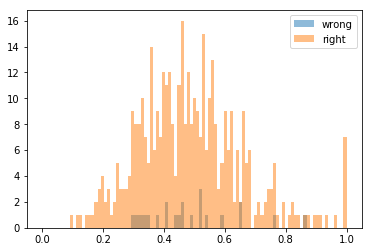

------- Compact Score: ReockPS ----------
Number wrong: 23 vs right: 405
Average compact score for wrong: 0.38235, right: 0.38239
P-value of ttest: 0.9986893162455028


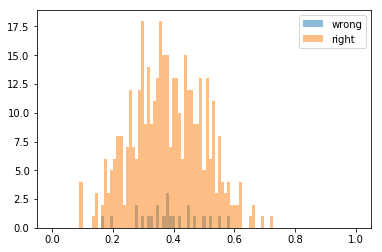

------- Compact Score: CvxHullPS ----------
Number wrong: 23 vs right: 405
Average compact score for wrong: 0.7163, right: 0.69885
P-value of ttest: 0.5058756715180652


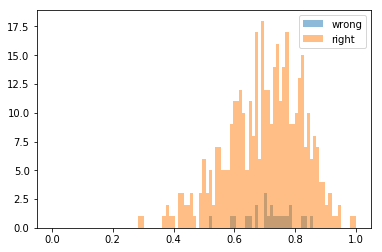

In [105]:
compact_version = 'ReockPTB'

for compact_version in ['ReockPTB', 'ReockPS', 'CvxHullPS']:
    wrong_compact_scores = []
    right_compact_scores = []
    for i in range(len(houseresults)):
        row = houseresults.iloc[i]
        prev_result = housedist_to_party[id_to_housedist[row['id']]]
        curr_result = 'democrat' if row['d_won'] else 'republican'
        compact_score = compact_df[compact_df['id'] == row['id']][compact_version].values
        if len(compact_score) != 1:
            print(compact_score)
            assert False
        compact_score = compact_score[0]
        if prev_result != curr_result:
            wrong_compact_scores.append(compact_score)
        else:
            right_compact_scores.append(compact_score)
    print("------- Compact Score: {} ----------".format(compact_version))
    
    print("Number wrong: {0} vs right: {1}".format(len(wrong_compact_scores), len(right_compact_scores)))
    print("Average compact score for wrong: {0}, right: {1}".format(round(np.mean(wrong_compact_scores), 5), round(np.mean(right_compact_scores), 5)))
    
    t, p = ttest_ind(wrong_compact_scores, right_compact_scores)
    print("P-value of ttest: {}".format(p))

    bins = np.linspace(0, 1., 100)

    plt.hist(wrong_compact_scores, bins, alpha=0.5, label='wrong')
    plt.hist(right_compact_scores, bins, alpha=0.5, label='right')
    plt.legend(loc='upper right')
    plt.show()
